In [21]:
import math
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.src.layers import Dense, LayerNormalization
from keras.src.losses import MeanSquaredError
from keras.src.saving import load_model
from matplotlib import pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

warnings.filterwarnings('ignore')

In [2]:
def wce(prediction, observed):
    label = tf.cast(observed > 0, tf.float32)

    loss = - tf.math.abs(observed) * (
            label * tf.math.log(prediction + 1e-9) + (1 - label) * tf.math.log(1 - prediction + 1e-9)
    )

    return tf.reduce_mean(loss)

In [3]:
#The data already obtained from yahoo finance is imported.
dataset = pd.read_csv('data/SP500.csv', index_col=0)
#Diable the warnings

type(dataset)

pandas.core.frame.DataFrame

In [4]:
print(dataset.shape)
pd.set_option('display.width', 100)
dataset.head(5)

(2516, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


<Axes: xlabel='Date'>

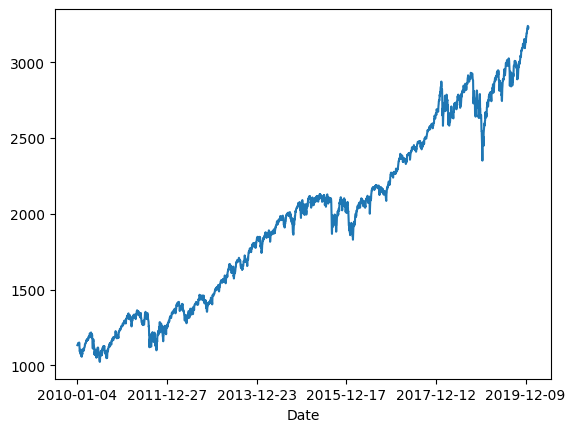

In [5]:
dataset['Close'].plot()

In [6]:
print('Null Values =', dataset.isnull().values.any())

Null Values = False


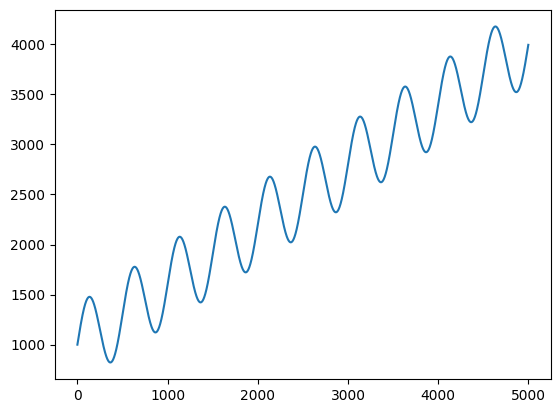

In [13]:
# TODO make t bigger

N = 5000

t = np.arange(N)
X = 1000 + 3000 * t / N + 400 * np.sin(20 * np.pi * t / N)
plt.plot(t, X)
plt.show()

In [7]:

# X = list(dataset["Close"])

# X = [float(x) for x in X]

In [14]:
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

In [15]:
X_train = np.array(X_train)
X_test = np.array(X_test)
print(X_train.shape)
print(X_test.shape)

(4000,)
(1000,)


In [16]:
state_size = 8
X_episodes = sliding_window_view(X_train[:-1], state_size)
print(X_episodes.shape)
X_episodes_test = sliding_window_view(X_test[:-1], state_size)
print(X_episodes_test.shape)

(3992, 8)
(992, 8)


In [17]:
X_episodes

array([[1000.        , 1005.62641595, 1011.25203818, ..., 1028.11620781,
        1033.73072221, 1039.34047862],
       [1005.62641595, 1011.25203818, 1016.87607307, ..., 1033.73072221,
        1039.34047862, 1044.94468594],
       [1011.25203818, 1016.87607307, 1022.49772727, ..., 1039.34047862,
        1044.94468594, 1050.54255395],
       ...,
       [3338.28388373, 3343.86670657, 3349.45744605, ..., 3366.26927779,
        3371.88379219, 3377.50227273],
       [3343.86670657, 3349.45744605, 3355.05531406, ..., 3371.88379219,
        3377.50227273, 3383.12392693],
       [3349.45744605, 3355.05531406, 3360.65952138, ..., 3377.50227273,
        3383.12392693, 3388.74796182]])

In [18]:
y_train = X_train[8:] - X_train[7:-1]
print(y_train.shape)
y_test = X_test[8:] - X_test[7 - 1]
print(y_test.shape)

(3992,)
(992,)


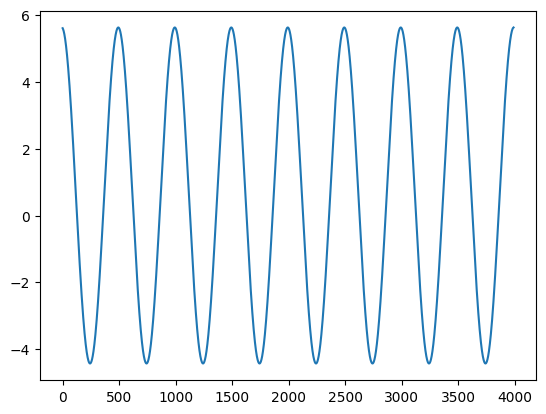

In [19]:
plt.plot(np.arange(len(y_train)), y_train)
plt.show()

In [20]:
stupid_model = y_test.mean()

In [22]:
class MSEAgent:
    def __init__(self, state_size, is_eval=False, model_name="", loss_function='mse'):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size  # normalized previous days,
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.loss_function = loss_function

        self.model = load_model(model_name) if is_eval else self._model()

    def _model(self):
        model = Sequential()
        model.add(LayerNormalization(input_dim=self.state_size))
        model.add(Dense(units=self.state_size // 2, activation="relu"))
        model.add(Dense(units=self.state_size // 4, activation="relu"))
        model.add(Dense(1, activation="linear"))
        model.compile(loss='mse', optimizer='adam')
        return model

    def act(self, state):
        options = self.model.predict(state)
        return np.argmax(options[0])

    def train(self, X, y, batch_size, X_test, y_test, epochs):
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

In [23]:
X_episodes_test[:, -1] - X_episodes_test[:, -2]

array([ 5.60975641e+00,  5.60420732e+00,  5.59786801e+00,  5.59073948e+00,
        5.58282285e+00,  5.57411937e+00,  5.56463043e+00,  5.55435751e+00,
        5.54330224e+00,  5.53146637e+00,  5.51885176e+00,  5.50546041e+00,
        5.49129443e+00,  5.47635606e+00,  5.46064765e+00,  5.44417169e+00,
        5.42693078e+00,  5.40892764e+00,  5.39016512e+00,  5.37064617e+00,
        5.35037389e+00,  5.32935146e+00,  5.30758222e+00,  5.28506959e+00,
        5.26181713e+00,  5.23782853e+00,  5.21310755e+00,  5.18765811e+00,
        5.16148423e+00,  5.13459003e+00,  5.10697978e+00,  5.07865781e+00,
        5.04962862e+00,  5.01989677e+00,  4.98946698e+00,  4.95834403e+00,
        4.92653286e+00,  4.89403847e+00,  4.86086601e+00,  4.82702070e+00,
        4.79250790e+00,  4.75733306e+00,  4.72150172e+00,  4.68501955e+00,
        4.64789231e+00,  4.61012585e+00,  4.57172616e+00,  4.53269928e+00,
        4.49305138e+00,  4.45278873e+00,  4.41191767e+00,  4.37044467e+00,
        4.32837627e+00,  

In [24]:
def stupid_model(x):
    y = x[:, -1] - x[:, -2]
    return y

In [25]:
loss_function = MeanSquaredError()
baseline_prediction = y_train.mean()
baseline_predictions = np.full_like(y_test, baseline_prediction)
baseline_mse = loss_function(y_test, baseline_predictions).numpy()
s = stupid_model(X_episodes_test)
print(s.shape)
naive_baseline_mse = loss_function(y_test, s).numpy()
print("Baseline (Average) MSE:", baseline_mse)
print("Naive model", naive_baseline_mse)

(992,)
Baseline (Average) MSE: 143373.42
Naive model 143353.36


2024-10-23 13:39:58.965554: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 13:39:59.147860: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [26]:
agent = MSEAgent(state_size)
predictions = agent.model.predict(X_episodes_test)
val_loss = loss_function(y_test, predictions).numpy()
print(val_loss)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
143795.1


In [27]:
agent.train(X_episodes, y_train, 32, X_episodes_test, y_test, 500)

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10.7256 - val_loss: 144243.5938
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 8.4473 - val_loss: 144266.0938
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 8.4142 - val_loss: 144234.1719
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 7.3582 - val_loss: 144199.9531
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 7.0957 - val_loss: 144172.9062
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 6.9850 - val_loss: 144103.0938
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4199 - val_loss: 144095.7188
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0051 - val_loss: 144038.6875
Epoch 9/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7496 - val_loss: 144001.0781
Epoch 10/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 5.5832 - val_loss: 144001.2969
Epoch 11/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 5.

In [15]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


def get_state(data, t, n):
    d = t - n + 1
    print(d)
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

3


array([[9.64085505e-01, 8.80797078e-01, 2.12313811e-05, 9.99922106e-01,
        9.41580329e-01, 3.99712183e-06, 9.99999319e-01]])

In [ ]:


# prints formatted price
def format_price(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))


def get_state(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]  # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])


# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label='Buying signal', markevery=states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label='Selling signal', markevery=states_sell)
    plt.title(f'Total gains: {profit}')
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()